In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.stats import kruskal
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import shap
from sklearn.preprocessing import MaxAbsScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")


# Configure plot styling
plt.style.use("classic")
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.facecolor": "white",
    "font.family": "serif",
    "figure.dpi": 200,
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16,
})


In [99]:
# --- STEP 1: Load and Preprocess Data ---
def preprocess_for_pca_and_clustering(file_path: str) -> tuple:
    """
    Preprocess the physiological and subjective data from the given CSV file.
    Adds delta features, scales them, inverts temperature features (to align with stress),
    and returns both the enriched original dataframe and a scaled DataFrame ready for PCA/clustering.

    Returns:
        df_full: Original DataFrame enriched with new delta features
        df_scaled: Scaled and aligned delta features ready for PCA/clustering
    """
    # Load the data
    df = pd.read_csv(file_path)

    # Temperature features to invert sign early
    temp_cols_to_invert = [
        'Base_TEMP_TD_Mean', 'P2R1_TEMP_TD_Mean', 'P2R2_TEMP_TD_Mean',
        'P2R3_TEMP_TD_Mean', 'P2R4_TEMP_TD_Mean'
    ]
    df[temp_cols_to_invert] *= -1

    # Convert selected integer columns to float64
    int_columns = ['Base_HR_TD_Median', 'Base_TEMP_TD_Mean',
           'Base_EDA_TD_P_AUC', 'Base_EDA_TD_P_Peaks', 'Base_EDA_TD_T_AUC',
           'P2R1_HR_TD_Median', 'P2R1_TEMP_TD_Mean', 'P2R1_EDA_TD_P_AUC',
           'P2R1_EDA_TD_P_Peaks', 'P2R1_EDA_TD_T_AUC', 'P2R2_HR_TD_Median',
           'P2R2_TEMP_TD_Mean', 'P2R2_EDA_TD_P_AUC', 'P2R2_EDA_TD_P_Peaks',
           'P2R2_EDA_TD_T_AUC', 'P2R3_HR_TD_Median', 'P2R3_TEMP_TD_Mean',
           'P2R3_EDA_TD_P_AUC', 'P2R3_EDA_TD_P_Peaks', 'P2R3_EDA_TD_T_AUC',
           'P2R4_HR_TD_Median', 'P2R4_TEMP_TD_Mean', 'P2R4_EDA_TD_P_AUC',
           'P2R4_EDA_TD_P_Peaks', 'P2R4_EDA_TD_T_AUC', 'P3R1_EDA_TD_P_ReT',
           'P3R2_EDA_TD_P_ReT', 'P3R3_EDA_TD_P_ReT', 'P3R4_EDA_TD_P_ReT',
           'Base_frustration', 'Base_PA', 'Base_NA', 'P2R1_frustration', 'P2R1_PA',
           'P2R1_NA', 'P2R2_frustration', 'P2R2_PA', 'P2R2_NA', 'P2R3_frustration',
           'P2R3_PA', 'P2R3_NA', 'P2R4_frustration', 'P2R4_PA', 'P2R4_NA',
           'std_HR', ' std_TEMP', 'std_EDA_P', 'std_EDA_T']
    df[int_columns] = df[int_columns].astype("float64")

    # Rename columns for consistency
    rename_map = {
        'Base_HR_TD_Median': '0_hr', 'Base_TEMP_TD_Mean': '0_temp',
        'Base_EDA_TD_P_AUC': '0_edaP', 'Base_EDA_TD_P_Peaks': '0_eda_peaks',
        'Base_EDA_TD_T_AUC': '0_edaT', 'Base_frustration': '0_frustration',
        'Base_PA': '0_pa', 'Base_NA': '0_na',
        'P2R1_HR_TD_Median': '1_hr', 'P2R1_TEMP_TD_Mean': '1_temp',
        'P2R1_EDA_TD_P_AUC': '1_edaP', 'P2R1_EDA_TD_P_Peaks': '1_eda_peaks',
        'P2R1_EDA_TD_T_AUC': '1_edaT', 'P2R1_frustration': '1_frustration',
        'P2R1_PA': '1_pa', 'P2R1_NA': '1_na',
        'P2R2_HR_TD_Median': '2_hr', 'P2R2_TEMP_TD_Mean': '2_temp',
        'P2R2_EDA_TD_P_AUC': '2_edaP', 'P2R2_EDA_TD_P_Peaks': '2_eda_peaks',
        'P2R2_EDA_TD_T_AUC': '2_edaT', 'P2R2_frustration': '2_frustration',
        'P2R2_PA': '2_pa', 'P2R2_NA': '2_na',
        'P2R3_HR_TD_Median': '3_hr', 'P2R3_TEMP_TD_Mean': '3_temp',
        'P2R3_EDA_TD_P_AUC': '3_edaP', 'P2R3_EDA_TD_P_Peaks': '3_eda_peaks',
        'P2R3_EDA_TD_T_AUC': '3_edaT', 'P2R3_frustration': '3_frustration',
        'P2R3_PA': '3_pa', 'P2R3_NA': '3_na',
        'P2R4_HR_TD_Median': '4_hr', 'P2R4_TEMP_TD_Mean': '4_temp',
        'P2R4_EDA_TD_P_AUC': '4_edaP', 'P2R4_EDA_TD_P_Peaks': '4_eda_peaks',
        'P2R4_EDA_TD_T_AUC': '4_edaT', 'P2R4_frustration': '4_frustration',
        'P2R4_PA': '4_pa', 'P2R4_NA': '4_na',
        'P3R1_EDA_TD_P_ReT': '1_eda_ret', 'P3R2_EDA_TD_P_ReT': '2_eda_ret',
        'P3R3_EDA_TD_P_ReT': '3_eda_ret', 'P3R4_EDA_TD_P_ReT': '4_eda_ret'
    }
    df.rename(columns=rename_map, inplace=True)

    # Create deltas
    for i in range(1, 5):
        prev = str(i - 1)
        for metric in ['hr', 'temp', 'edaP', 'eda_peaks', 'edaT']:
            df[f'delta_{metric}{i}'] = df[f'{i}_{metric}'] - df[f'{prev}_{metric}']
        for affect in ['frustration', 'pa', 'na']:
            df[f'delta_{affect}_translation{i}'] = df[f'{i}_{affect}'] - df[f'{prev}_{affect}']
    for i in range(2, 5):
        df[f'delta_recovery{i}'] = df[f'{i}_eda_ret'] - df[f'{i-1}_eda_ret']

    # Scale delta features - Apply MaxAbsScaler
    delta_cols = [col for col in df.columns if col.startswith('delta_')]
    scaler = MaxAbsScaler()
    df_scaled = df.copy()
    df_scaled[delta_cols] = scaler.fit_transform(df[delta_cols])

    return df, df_scaled[delta_cols]


df_full, df_pca_ready = preprocess_for_pca_and_clustering('HR_data_dim2.csv')
df_pca_ready['Individual'] = df['Individual']
# Merge on 'Individual'
df_merged = df.merge(df_pca_ready, on='Individual')

c = pd.read_csv('clusters1.csv')
df_mearged = df_merged.merge(c, on='Individual')

delta_cols = ['delta_hr1', 'delta_temp1', 'delta_edaP1', 'delta_eda_peaks1',
       'delta_edaT1', 'delta_frustration_translation1',
       'delta_pa_translation1', 'delta_na_translation1', 'delta_hr2',
       'delta_temp2', 'delta_edaP2', 'delta_eda_peaks2', 'delta_edaT2',
       'delta_frustration_translation2', 'delta_pa_translation2',
       'delta_na_translation2', 'delta_hr3', 'delta_temp3', 'delta_edaP3',
       'delta_eda_peaks3', 'delta_edaT3', 'delta_frustration_translation3',
       'delta_pa_translation3', 'delta_na_translation3', 'delta_hr4',
       'delta_temp4', 'delta_edaP4', 'delta_eda_peaks4', 'delta_edaT4',
       'delta_frustration_translation4', 'delta_pa_translation4',
       'delta_na_translation4', 'delta_recovery2', 'delta_recovery3',
       'delta_recovery4']
alignment_scores = []

for i in range(df_merged.shape[0]):
    phys = []
    subj = []
    for r in ['1', '2', '3', '4']:
        phys_chunk = [
            df_merged.loc[i, f'delta_hr{r}'],
            df_merged.loc[i, f'delta_temp{r}'],
            df_merged.loc[i, f'delta_edaP{r}'],
            df_merged.loc[i, f'delta_edaT{r}']
        ]
        subj_chunk = [
            df_merged.loc[i, f'delta_frustration_translation{r}'],
            df_merged.loc[i, f'delta_pa_translation{r}'],
            df_merged.loc[i, f'delta_na_translation{r}']
        ]
        phys.append(np.mean(phys_chunk))
        subj.append(np.mean(subj_chunk))

    if np.std(phys) > 0 and np.std(subj) > 0:
        corr = np.corrcoef(phys, subj)[0, 1]
    else:
        corr = np.nan
    alignment_scores.append(corr)

# Save to df_merged
df_merged['alignment_index'] = alignment_scores



In [103]:
df2 = df_merged

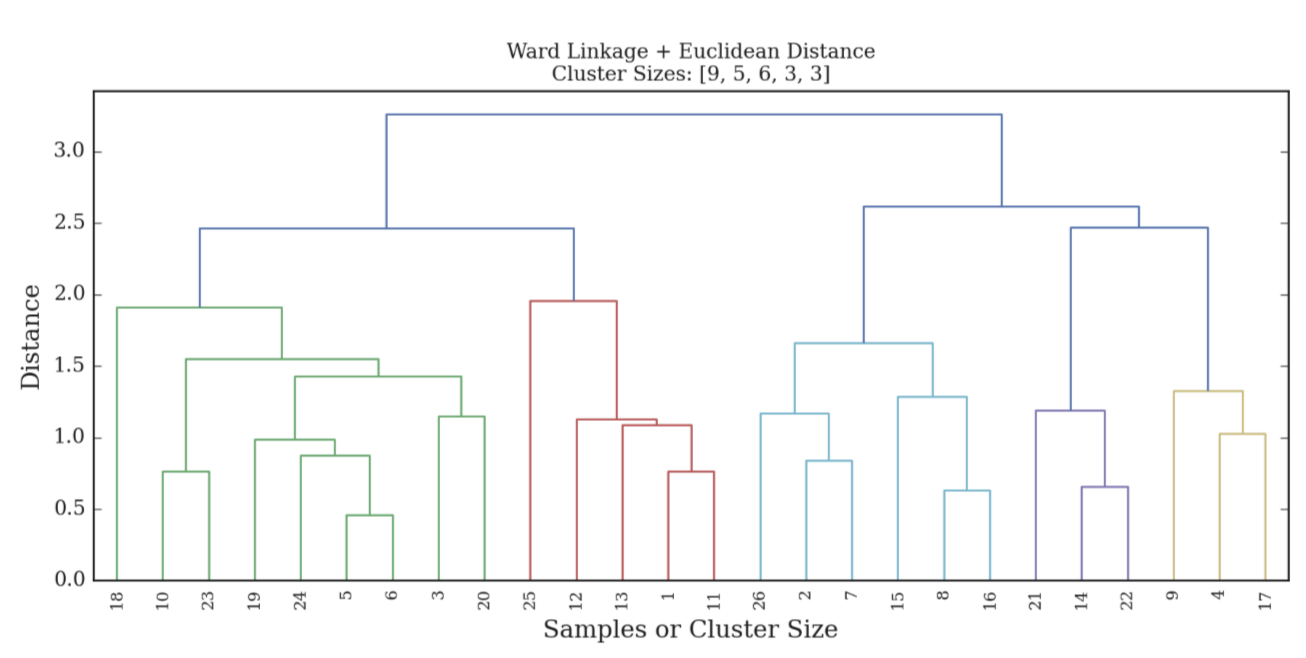

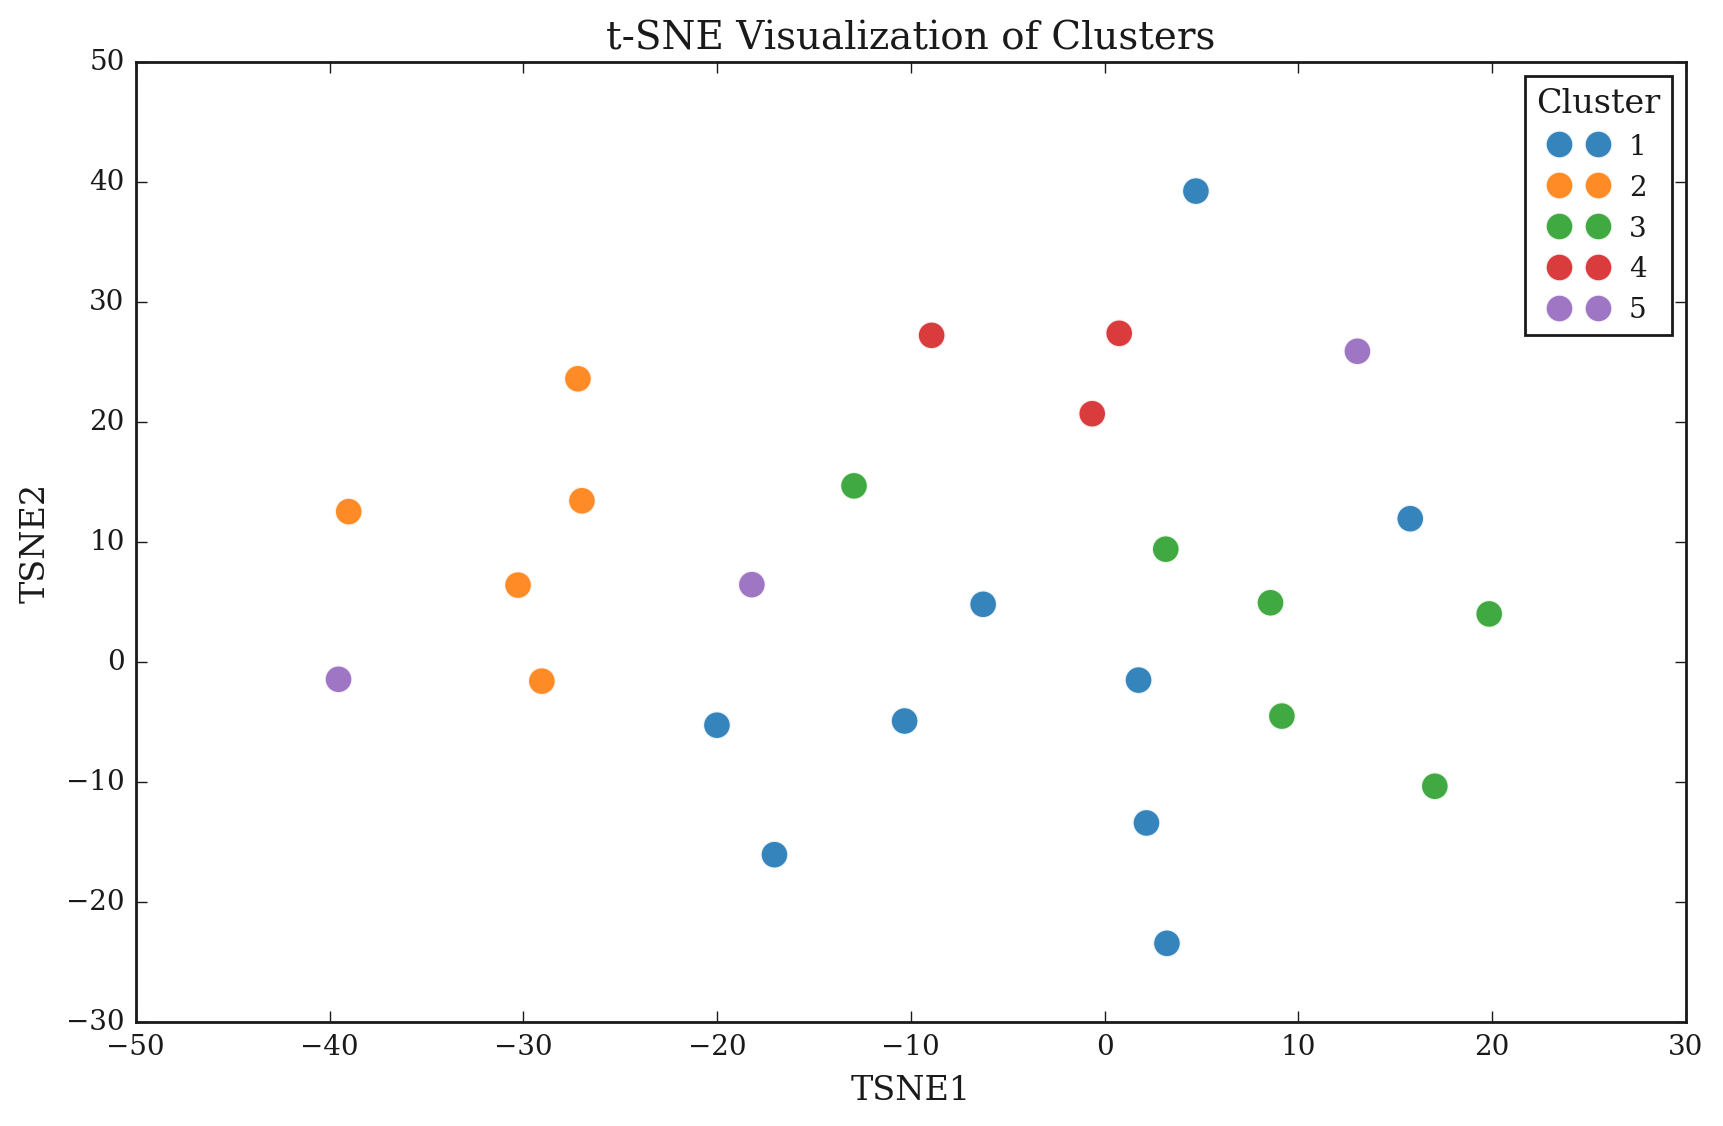

In [106]:
# Create a DataFrame for plotting
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = df2['Cluster'].astype(str)  # Ensure clusters are categorical

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1', y='TSNE2',
    hue='Cluster', palette='tab10', s=100, alpha=0.9
)
plt.title("t-SNE Visualization of Clusters", fontsize=14)
plt.legend(title="Cluster")
plt.show()


In [109]:
# Ensure all delta_cols are present in df2
features_available = [f for f in delta_cols if f in df2.columns]

# Perform ANOVA across clusters
anova_results = []
for feature in features_available:
    try:
        groups = [group[feature].dropna().values for name, group in df2.groupby('Cluster')]
        if all(len(g) > 1 for g in groups):  # ensure valid group sizes
            fstat, pval = f_oneway(*groups)
            anova_results.append((feature, pval))
    except Exception:
        continue  # skip feature if any error occurs

# Sort and return top 10 features
top_features = sorted(anova_results, key=lambda x: x[1])[:10]
top_features


[('delta_edaP1', 3.9701540740667634e-05),
 ('delta_edaT2', 0.008562788490572758),
 ('delta_edaT3', 0.012592978889703895),
 ('delta_recovery4', 0.02307607884747535),
 ('delta_pa_translation3', 0.06087794193856396),
 ('delta_pa_translation1', 0.06886071019128848),
 ('delta_frustration_translation3', 0.140104800247318),
 ('delta_eda_peaks1', 0.16924890760425737),
 ('delta_recovery2', 0.17818146616292244),
 ('delta_edaT4', 0.18223914209605585)]

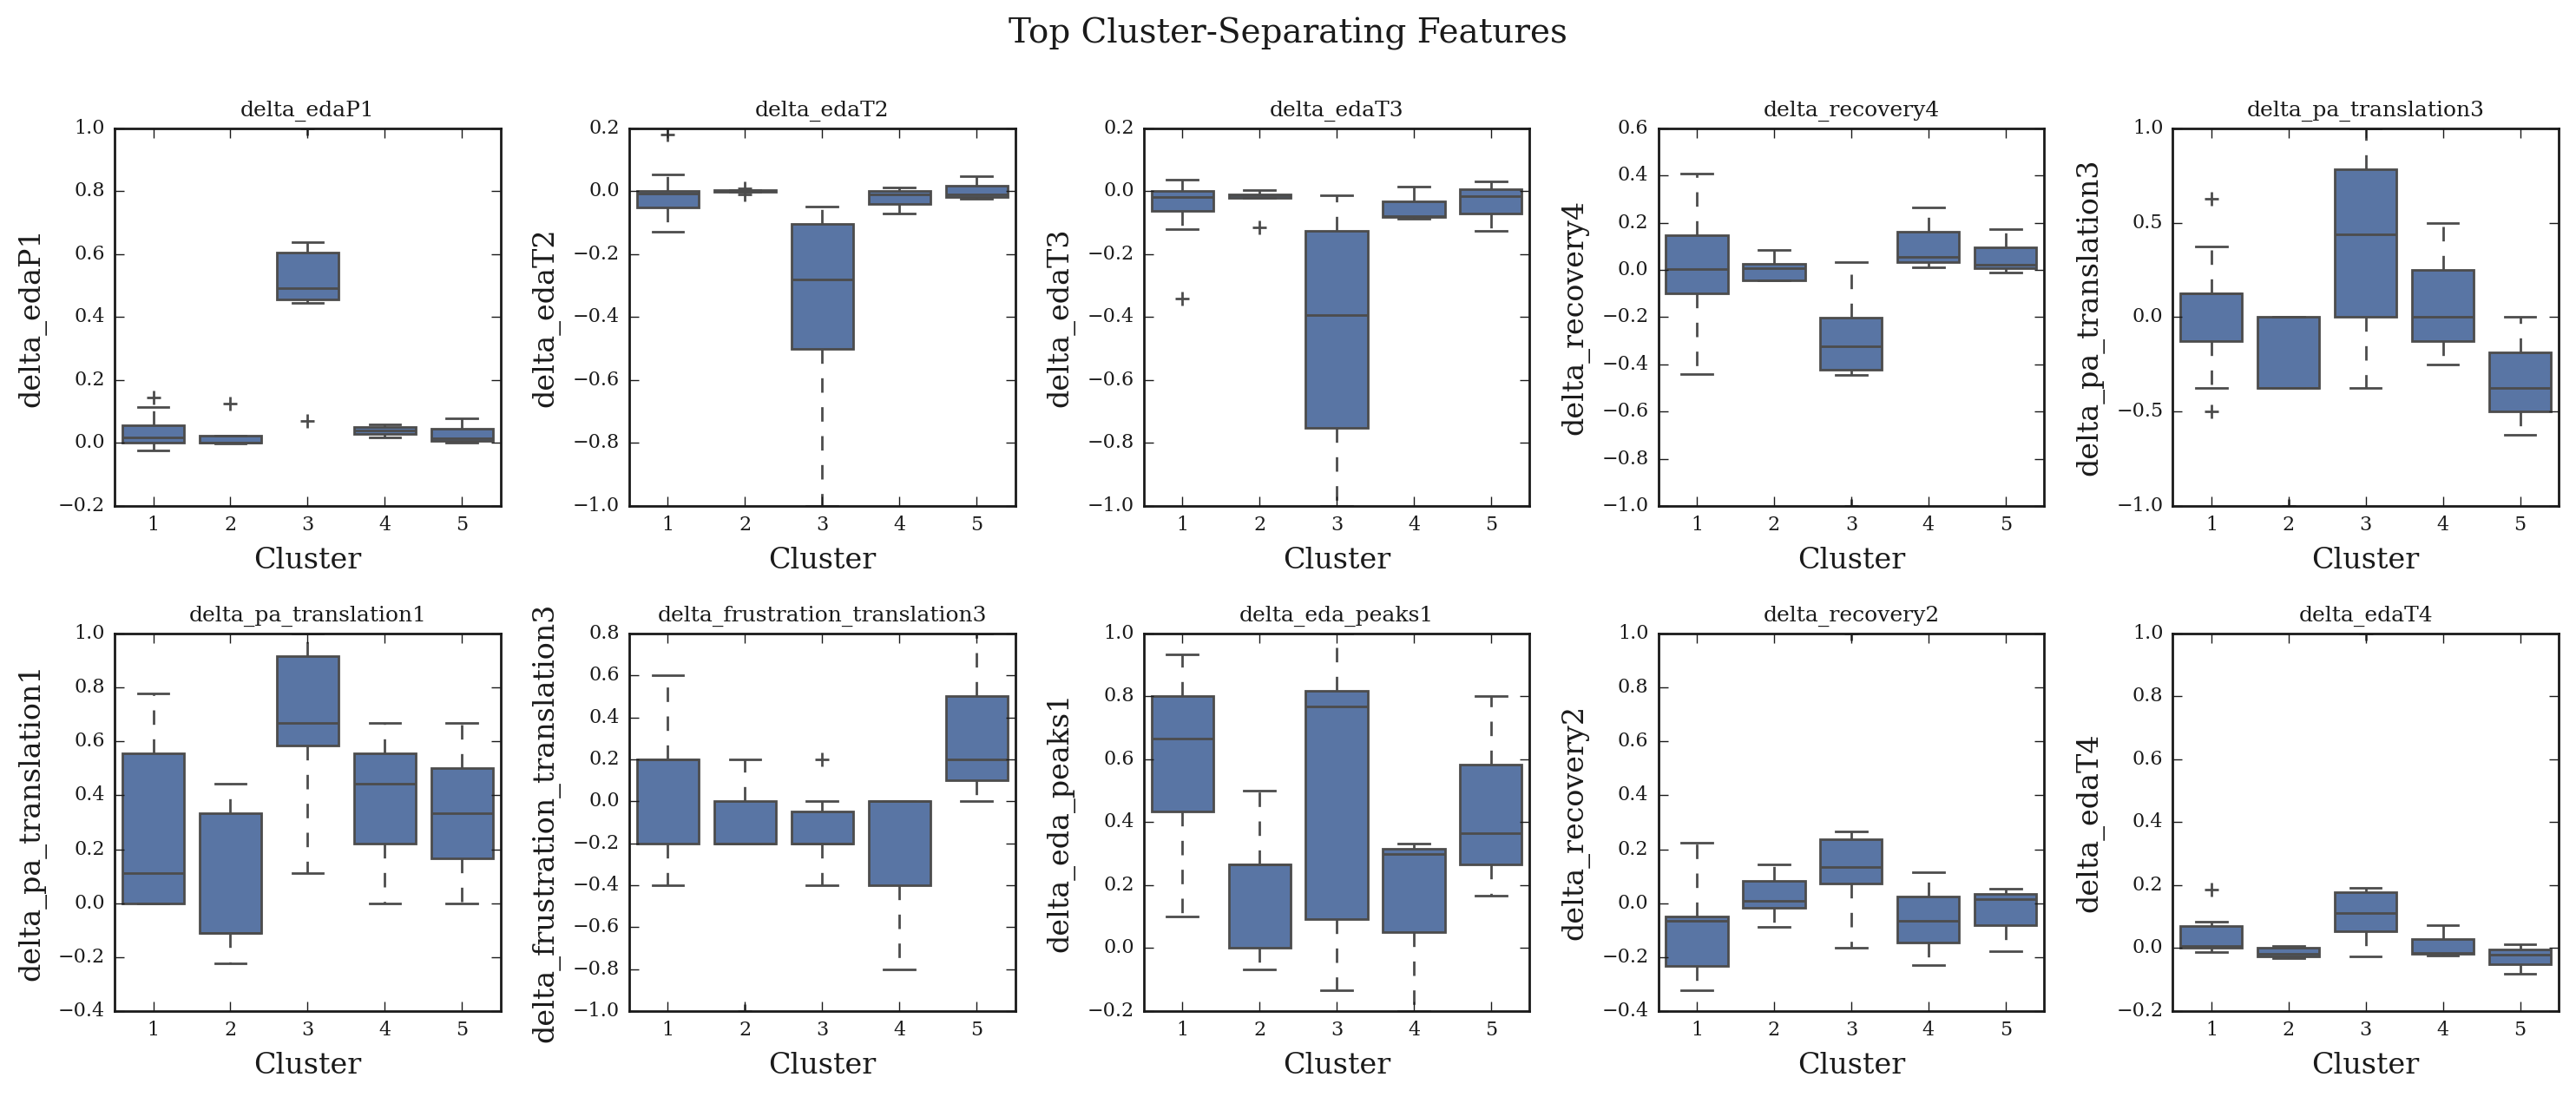

In [112]:
top_feature_names = [name for name, pval in top_features]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, feature in enumerate(top_feature_names):
    if feature in df2.columns:
        sns.boxplot(data=df2, x='Cluster', y=feature, ax=axes[i])
        axes[i].set_title(feature, fontsize=9)
        axes[i].tick_params(labelsize=8)

plt.tight_layout()
plt.suptitle("Top Cluster-Separating Features", fontsize=14, y=1.05)
plt.show()


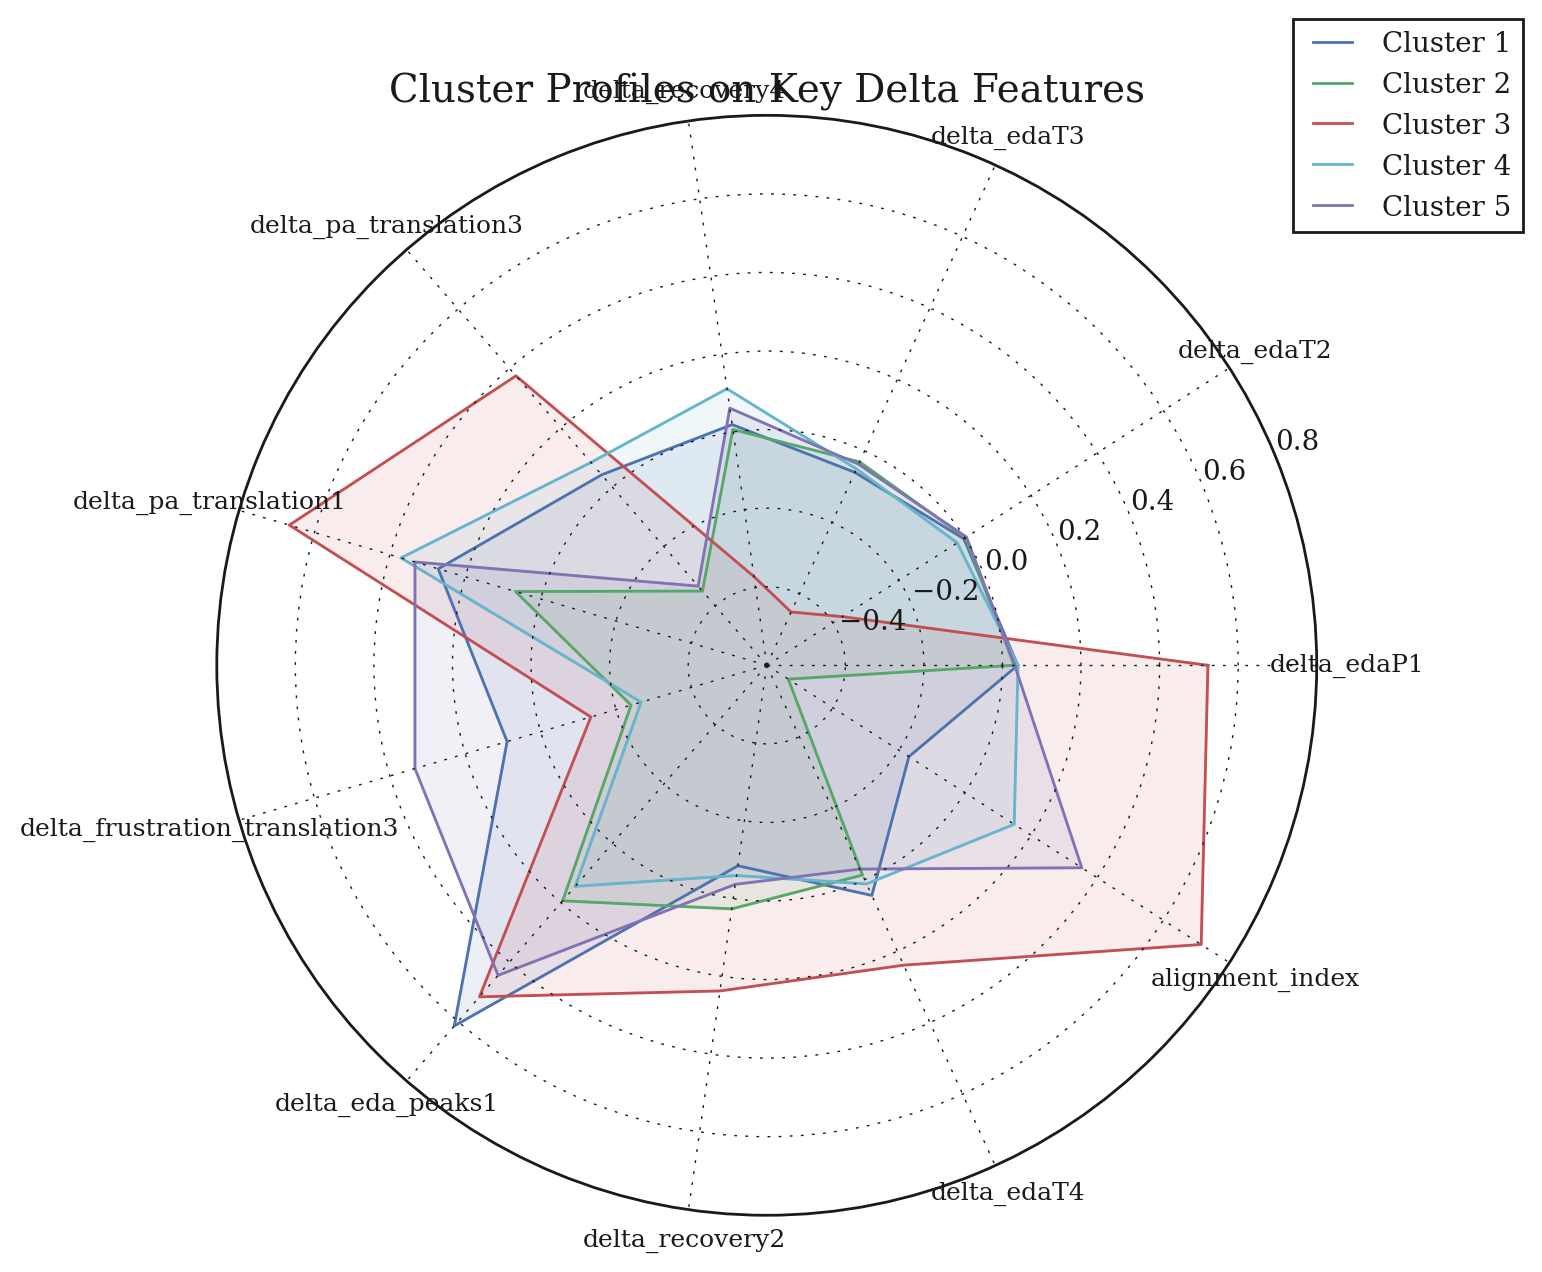

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Your top features
top_feature_names = [
    'delta_edaP1', 'delta_edaT2', 'delta_edaT3', 'delta_recovery4',
    'delta_pa_translation3', 'delta_pa_translation1',
    'delta_frustration_translation3', 'delta_eda_peaks1',
    'delta_recovery2', 'delta_edaT4', 'alignment_index'
]

# Group mean values by cluster
cluster_means = df2.groupby('Cluster')[top_feature_names].mean()

# Radar chart setup
num_vars = len(top_feature_names)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete loop

# Initialize plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each cluster
for cluster_id, row in cluster_means.iterrows():
    values = row.tolist()
    values += values[:1]  # close the shape
    ax.plot(angles, values, label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(top_feature_names, fontsize=9)
ax.set_title('Cluster Profiles on Key Delta Features', size=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


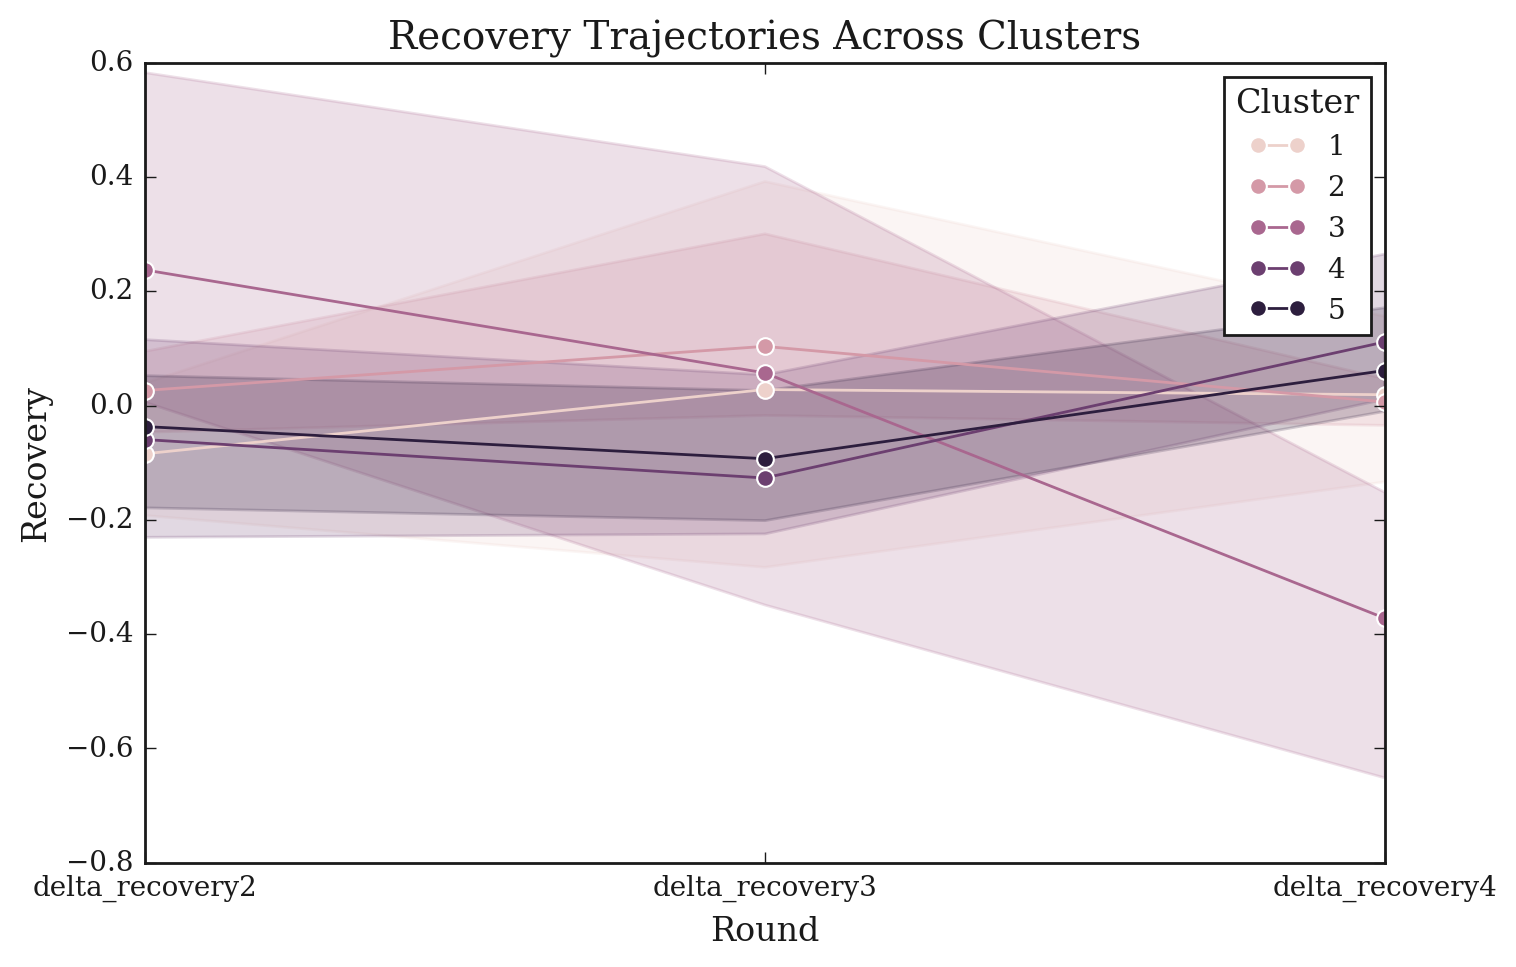

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = df2.melt(id_vars='Cluster', value_vars=['delta_recovery2', 'delta_recovery3', 'delta_recovery4'],
                   var_name='Round', value_name='Recovery')
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_melt, x='Round', y='Recovery', hue='Cluster', marker='o')
plt.title('Recovery Trajectories Across Clusters')
plt.show()


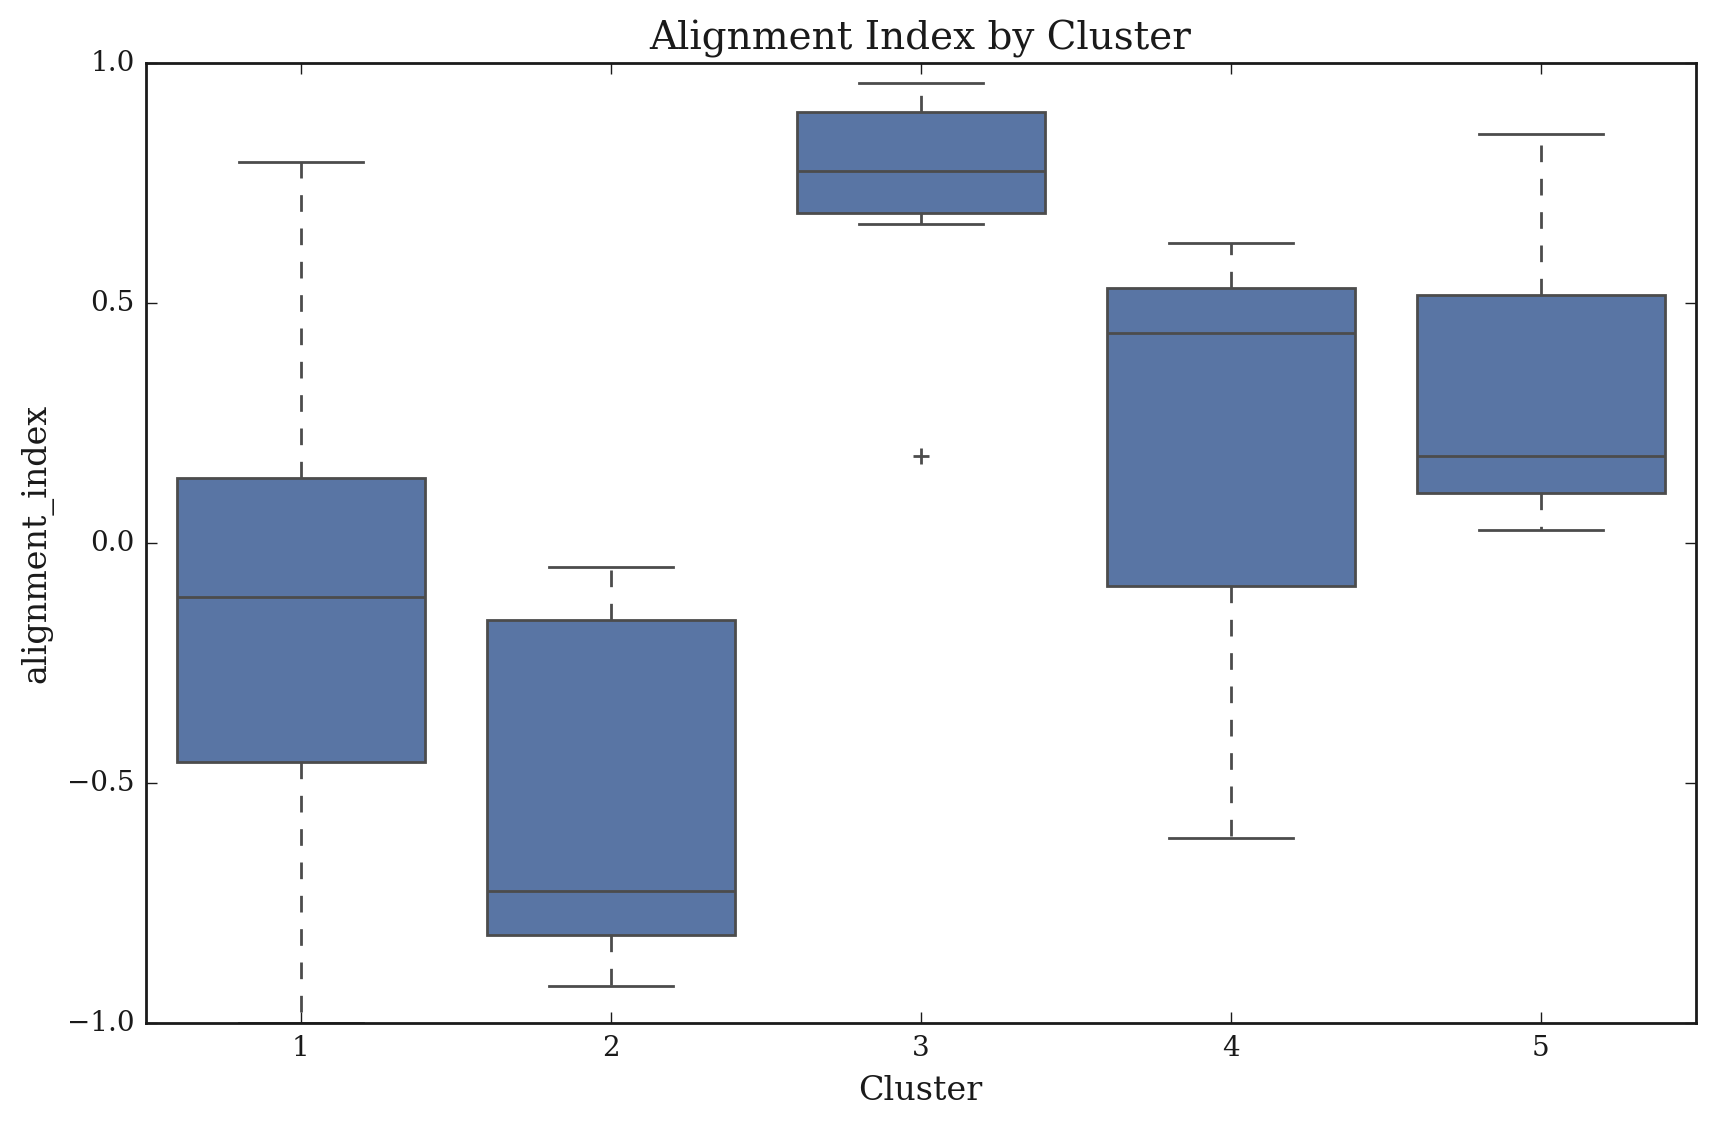

In [125]:
sns.boxplot(data=df2, x='Cluster', y='alignment_index')
plt.title("Alignment Index by Cluster")
plt.show()


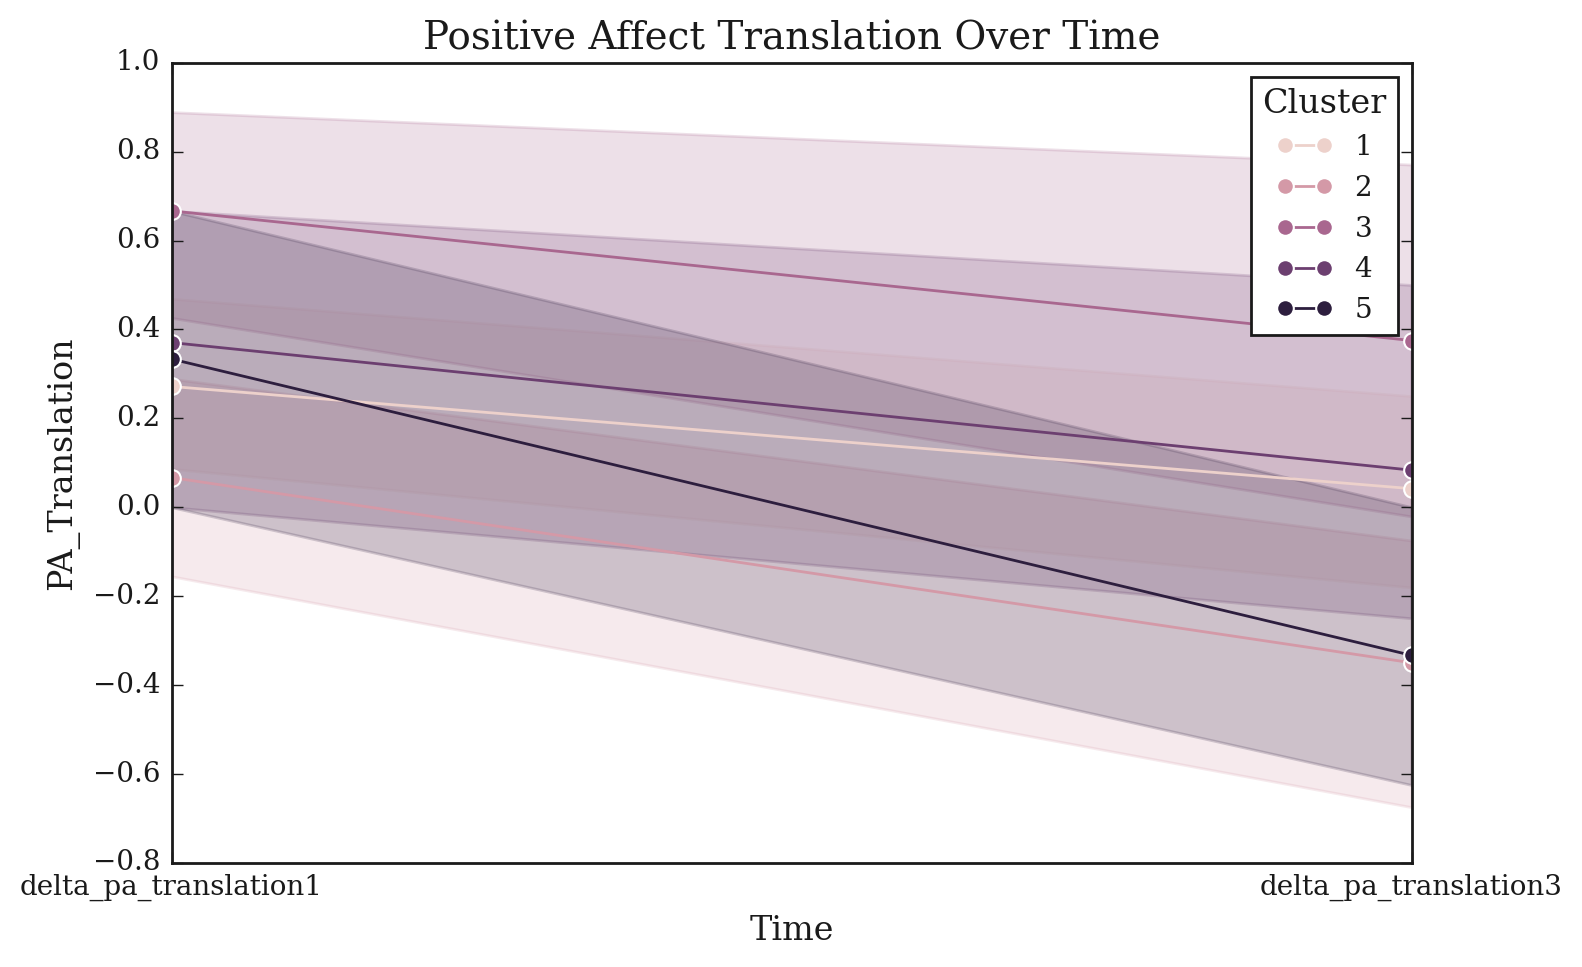

In [126]:
df_pa = df2.melt(id_vars='Cluster',
                 value_vars=['delta_pa_translation1', 'delta_pa_translation3'],
                 var_name='Time', value_name='PA_Translation')

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_pa, x='Time', y='PA_Translation', hue='Cluster', marker='o')
plt.title("Positive Affect Translation Over Time")
plt.show()


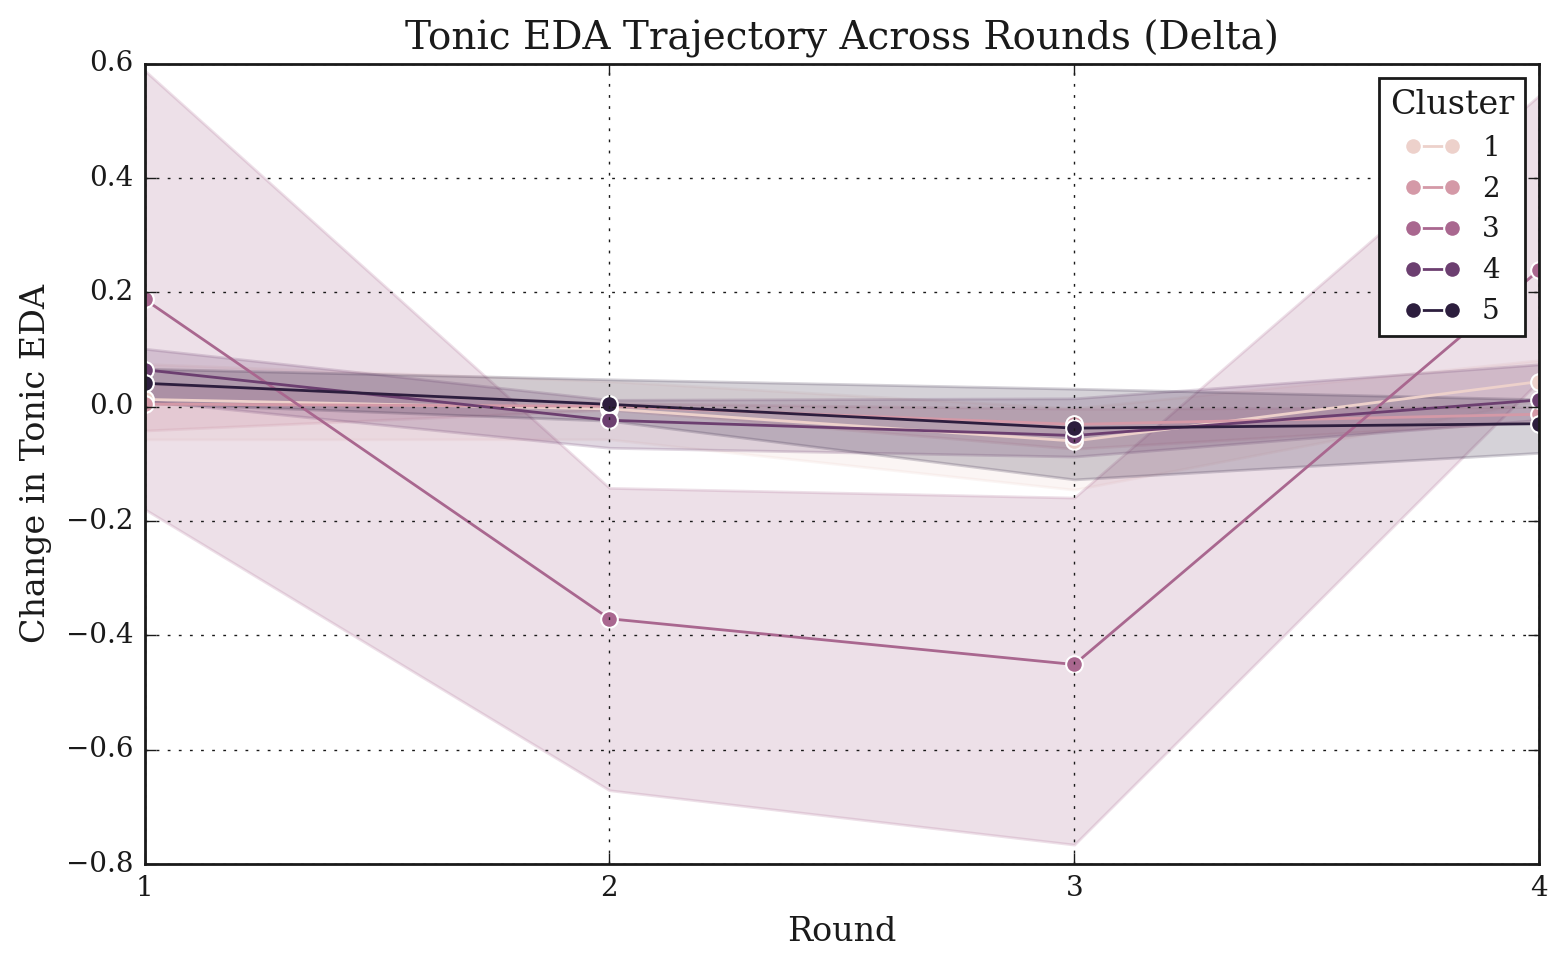

In [128]:
# Melt to long format
edaT_df = df2.melt(
    id_vars='Cluster',
    value_vars=['delta_edaT1', 'delta_edaT2', 'delta_edaT3', 'delta_edaT4'],
    var_name='Round',
    value_name='EDA_Tonic_Change'
)

# Clean round labels if needed
edaT_df['Round'] = edaT_df['Round'].str.extract(r'(\d)').astype(int)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=edaT_df, x='Round', y='EDA_Tonic_Change', hue='Cluster', marker='o')
plt.title("Tonic EDA Trajectory Across Rounds (Delta)", fontsize=14)
plt.ylabel("Change in Tonic EDA")
plt.xlabel("Round")
plt.xticks([1, 2, 3, 4])
plt.grid(True)
plt.tight_layout()
plt.show()


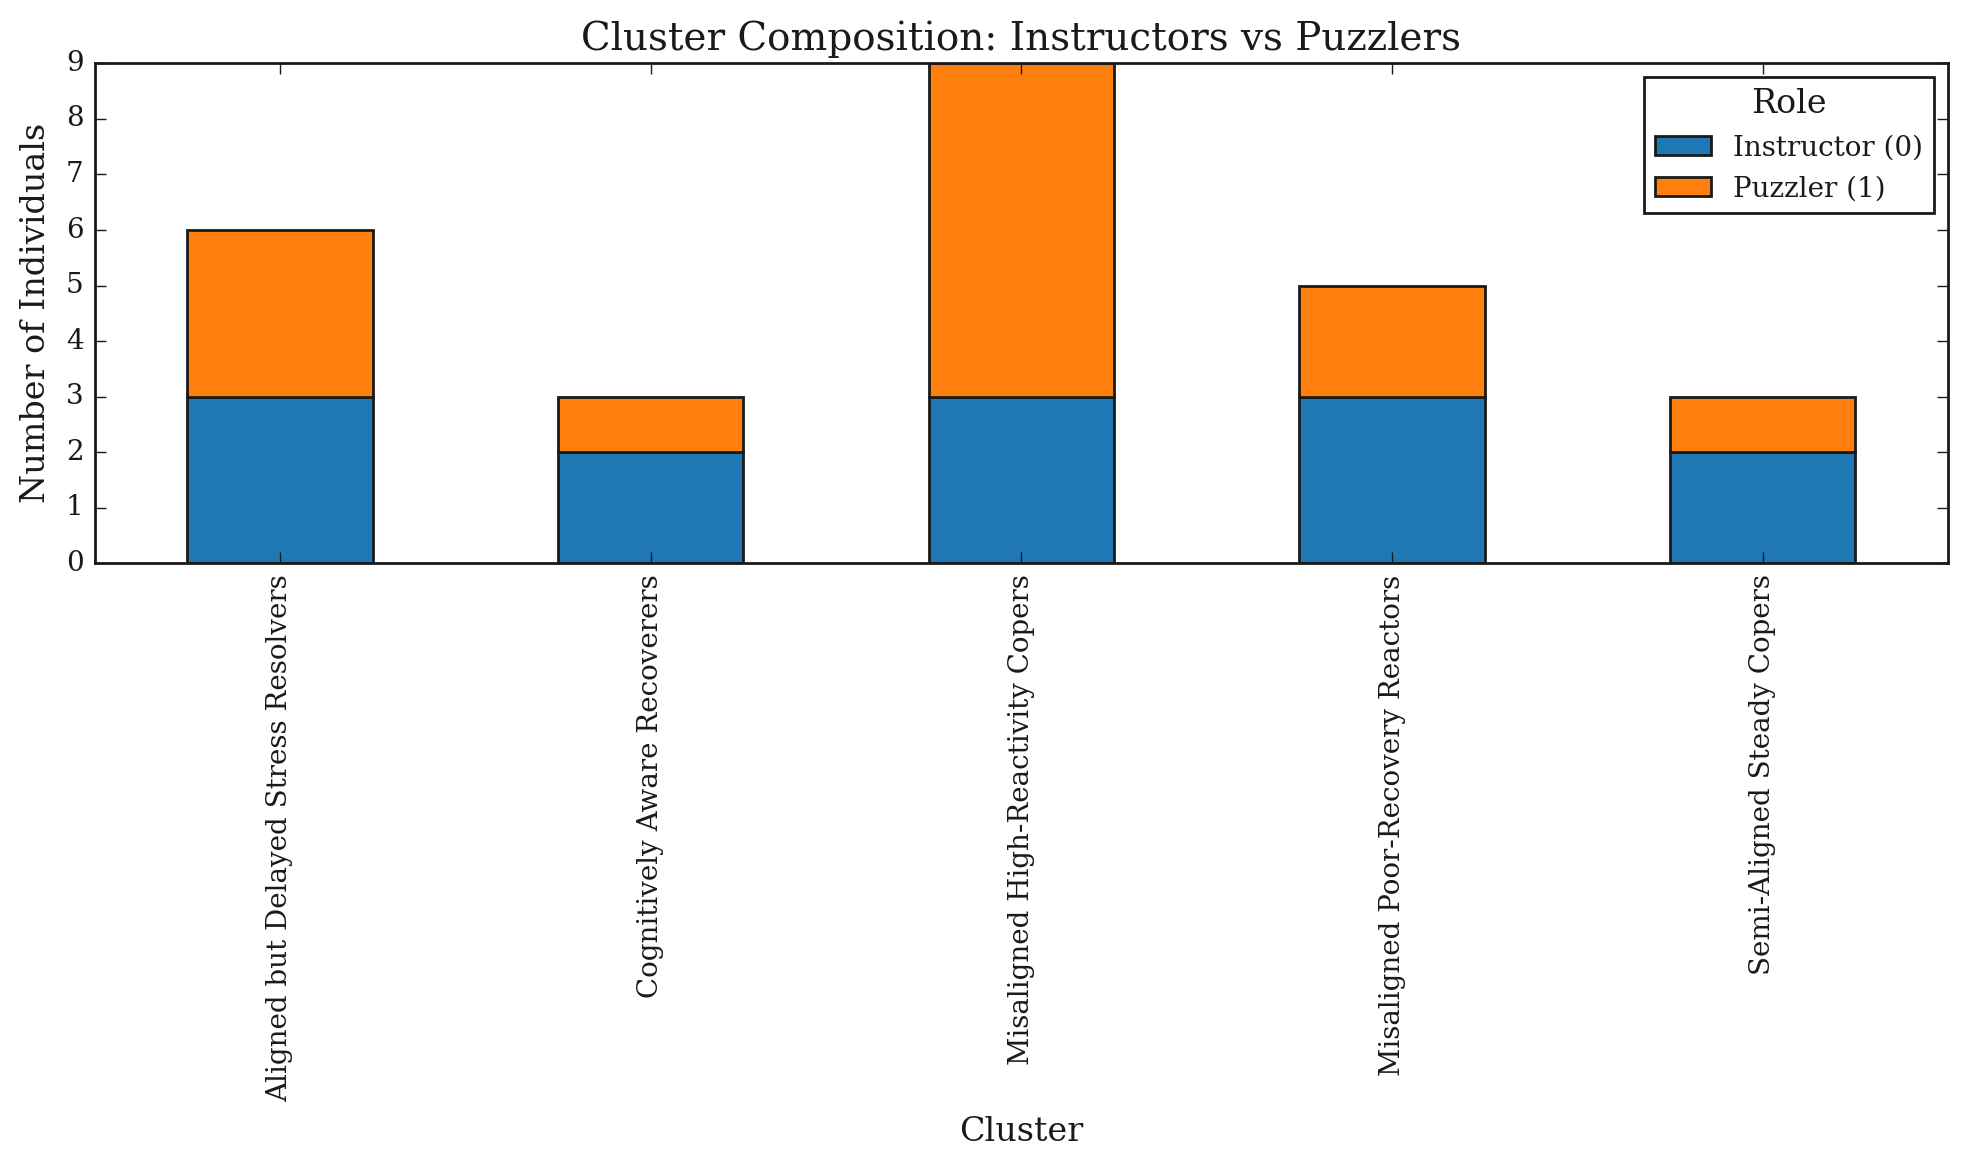

In [134]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Step 1: Assign affective labels
cluster_labels = {
    1: "Misaligned High-Reactivity Copers",
    2: "Misaligned Poor-Recovery Reactors",
    3: "Aligned but Delayed Stress Resolvers",
    4: "Semi-Aligned Steady Copers",
    5: "Cognitively Aware Recoverers"
}
df2["Cluster_Label"] = df2["Cluster"].map(cluster_labels)


# Step 3: Stacked bar plot showing cluster composition by Puzzler
cluster_puzzler_counts = df2.groupby(['Cluster_Label', 'Puzzler']).size().unstack(fill_value=0)
cluster_puzzler_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title("Cluster Composition: Instructors vs Puzzlers")
plt.xlabel("Cluster")
plt.ylabel("Number of Individuals")
plt.legend(["Instructor (0)", "Puzzler (1)"], title="Role")
plt.tight_layout()
plt.show()


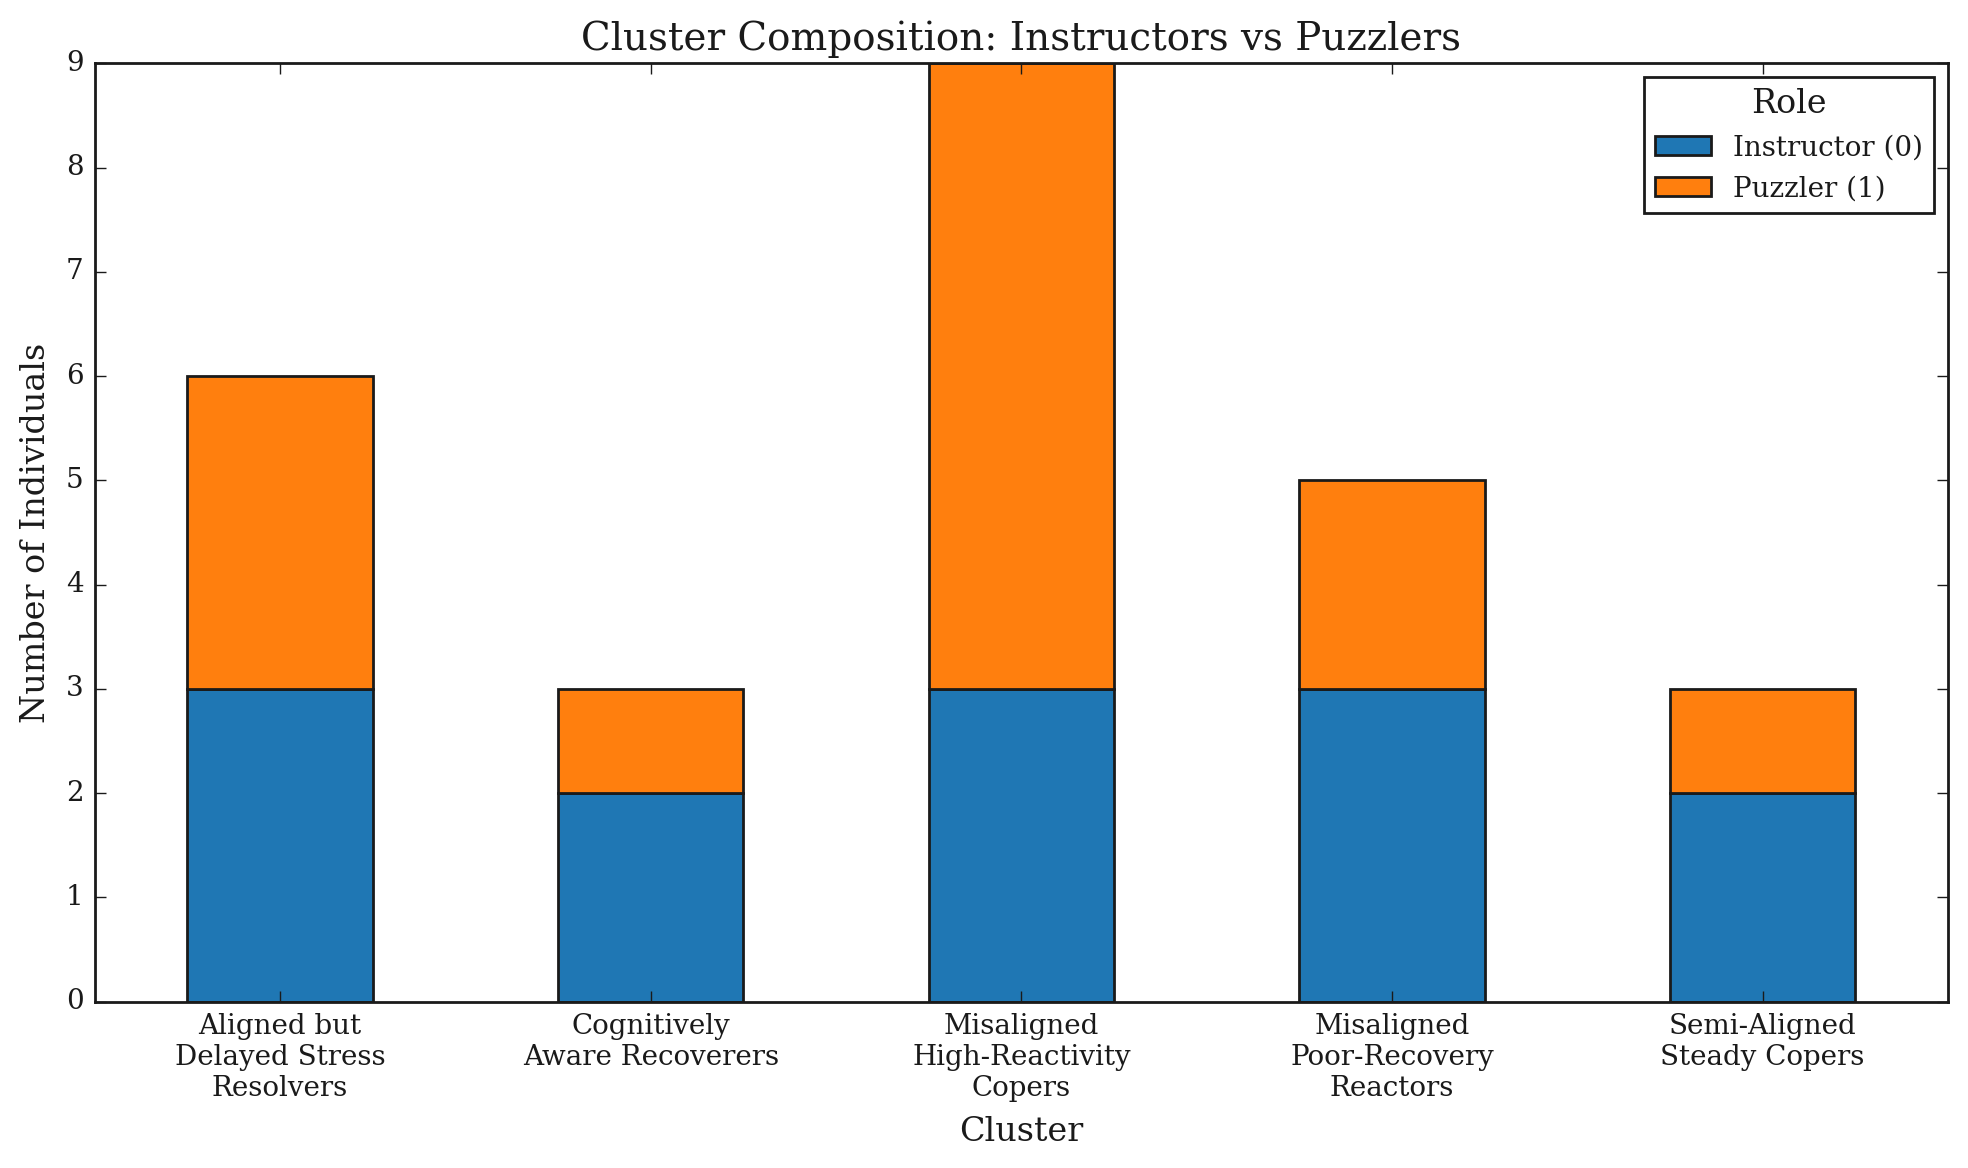

In [135]:
import matplotlib.pyplot as plt

# Step 1: Assign affective labels with line breaks for clarity
cluster_labels = {
    1: "Misaligned\nHigh-Reactivity\nCopers",
    2: "Misaligned\nPoor-Recovery\nReactors",
    3: "Aligned but\nDelayed Stress\nResolvers",
    4: "Semi-Aligned\nSteady Copers",
    5: "Cognitively\nAware Recoverers"
}
df2["Cluster_Label"] = df2["Cluster"].map(cluster_labels)

# Step 2: Create stacked bar plot with horizontal, multiline x-labels
cluster_puzzler_counts = df2.groupby(['Cluster_Label', 'Puzzler']).size().unstack(fill_value=0)
ax = cluster_puzzler_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title("Cluster Composition: Instructors vs Puzzlers")
plt.xlabel("Cluster")
plt.ylabel("Number of Individuals")
plt.legend(["Instructor (0)", "Puzzler (1)"], title="Role")

# Optional: Customize tick labels for better alignment
ax.set_xticklabels(cluster_puzzler_counts.index, rotation=0, ha='center')
plt.tight_layout()
plt.show()
